In [2]:
#GPU
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15101 MiB



# **Modern Convolutional Neural Networks (SE-ResNet-18)**

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import validation
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = tf.keras.layers.GlobalAveragePooling2D()
        self.excitation = tf.keras.models.Sequential([
            tf.keras.layers.Dense(channels // self.ratio, activation='relu'),
            tf.keras.layers.Dense(channels, activation='sigmoid')
        ])

    def call(self, inputs):
        se = self.squeeze(inputs)
        se = tf.keras.backend.expand_dims(se, axis=1)
        se = tf.keras.backend.expand_dims(se, axis=1)
        se = self.excitation(se)
        return inputs * se


class SEResidual(tf.keras.Model):
    """The Residual block of SE-ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        Y = self.se(Y)  # Applies SE block
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

# Defines SE-ResNet Blocks
class SEResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(SEResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    SEResidual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(SEResidual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

# Define SE-ResNet
def senet():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(96,96,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we created earlier
        SEResnetBlock(64, 2, first_block=True),
        SEResnetBlock(128, 2),
        SEResnetBlock(256, 2),
        SEResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10,activation='softmax')])

    loss= tf.keras.losses.CategoricalCrossentropy()

    # Sets Adam optimizer to 1e-4
    optimizer=tf.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate the model
model = senet()


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalizng the data
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def process_images(image, label):
    # Resize images from 32x32 to 96x96
    image = tf.image.resize(image, (96,96))
    return image, label



train_dataset = (train_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))
test_dataset = (test_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        9472      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 se_resnet_block (SEResnetB  (None, 24, 24, 64)        149896    
 lock)                                                           
                                                        

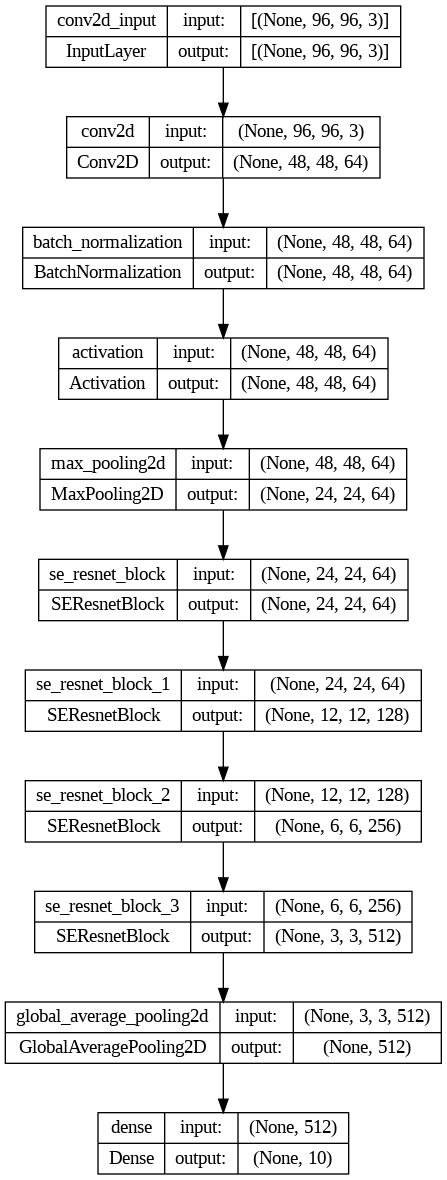

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
history = model.fit(train_dataset,
            epochs=50,
            batch_size = 32,
            validation_data=test_dataset)

Epoch 1/50
1562/1562 [==============================] - 83s 39ms/step - loss: 1.2166 - accuracy: 0.5637 - val_loss: 1.2454 - val_accuracy: 0.5809
Epoch 2/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.7651 - accuracy: 0.7324 - val_loss: 1.1811 - val_accuracy: 0.6165
Epoch 3/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.4969 - accuracy: 0.8290 - val_loss: 1.5415 - val_accuracy: 0.5629
Epoch 4/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.3055 - accuracy: 0.8960 - val_loss: 1.3201 - val_accuracy: 0.6580
Epoch 5/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.2092 - accuracy: 0.9271 - val_loss: 1.3915 - val_accuracy: 0.6781
Epoch 6/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.1444 - accuracy: 0.9506 - val_loss: 2.0576 - val_accuracy: 0.6061
Epoch 7/50
1562/1562 [==============================] - 61s 39ms/step - loss: 0.1224 - accuracy: 0.9565 - val_loss: 1.3287 -

In [11]:
# Get training and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Visualize the training and validation accuracy

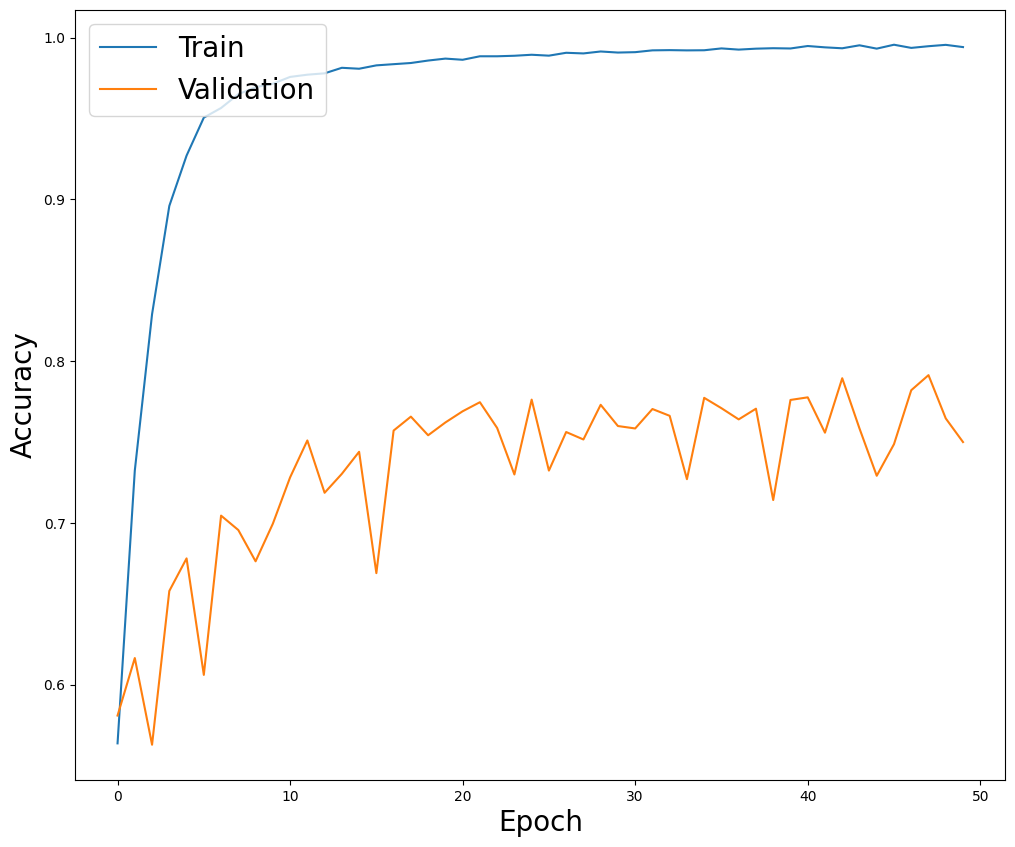

In [12]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Validation Accuracy')
    plt.legend(["Train", "Validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

# Evaluate the trained model

In [13]:
metrics = model.evaluate(test_dataset, verbose=0)
print("Test loss:", metrics[0])
print("Test accuracy:", metrics[1])

Test loss: 1.624327301979065
Test accuracy: 0.75


# Predict using the trained model

1/1 [==============================] - 2s 2s/step
Predicted class: 3 ( cat )
Actual class: 3 ( cat )


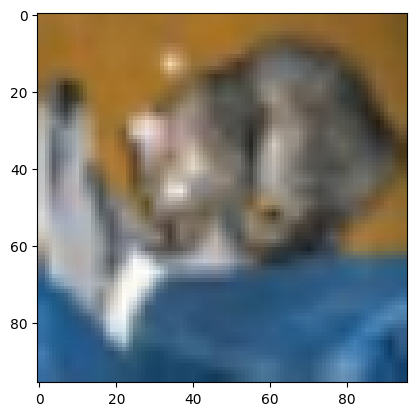

Predicted class: 8 ( ship )
Actual class: 8 ( ship )


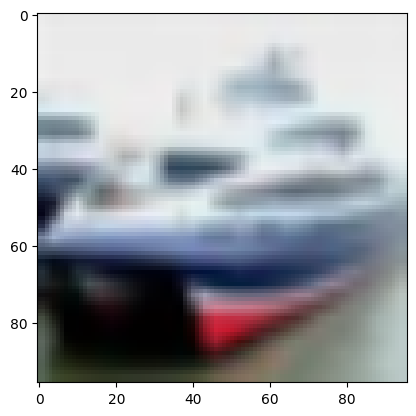

Predicted class: 8 ( ship )
Actual class: 8 ( ship )


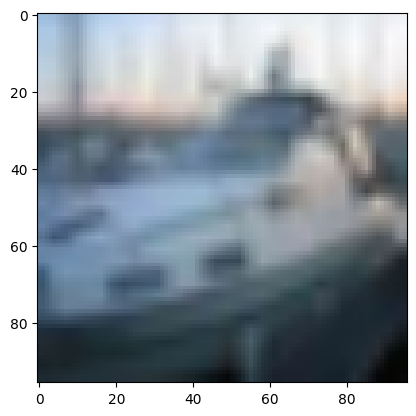

Predicted class: 0 ( airplane )
Actual class: 0 ( airplane )


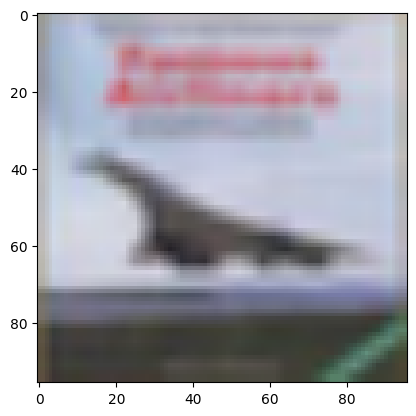

Predicted class: 6 ( frog )
Actual class: 6 ( frog )


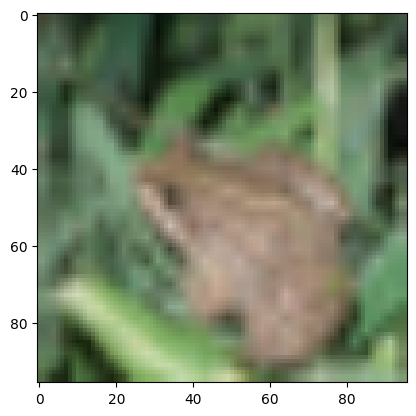

Predicted class: 6 ( frog )
Actual class: 6 ( frog )


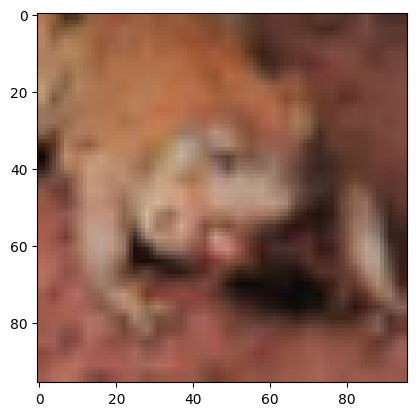

Predicted class: 1 ( automobile )
Actual class: 1 ( automobile )


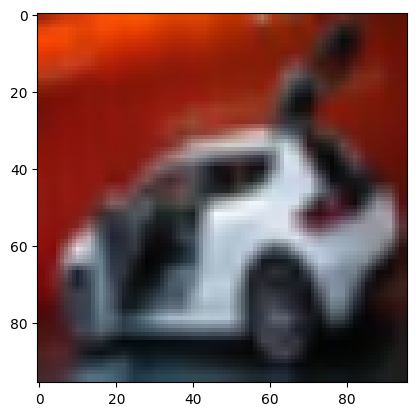

Predicted class: 2 ( bird )
Actual class: 6 ( frog )


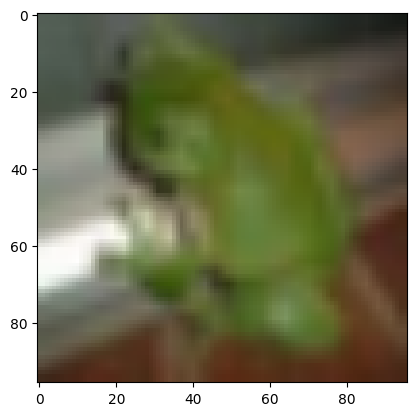

Predicted class: 3 ( cat )
Actual class: 3 ( cat )


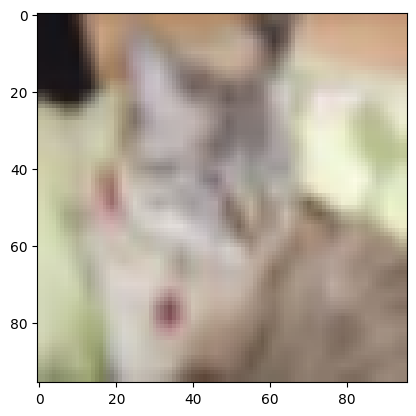

Predicted class: 1 ( automobile )
Actual class: 1 ( automobile )


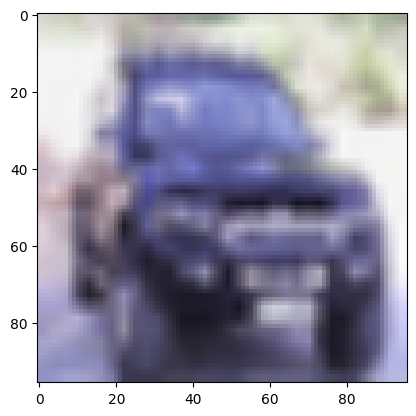


Mini-batch test accuracy: 90.0%


In [14]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
acc = 0

for images, labels in test_dataset.take(1):

    # Predicts on the first 10 examples
    predictions = model.predict(images[:10])

    # Shows predictions and corresponding images
    for i in range(10):
        predicted_class = tf.argmax(predictions[i]).numpy()
        actual_class = tf.argmax(labels[i]).numpy()
        predicted_class_name = class_names[predicted_class]
        actual_class_name = class_names[actual_class]
        print("Predicted class:", predicted_class, "(", predicted_class_name, ")")
        print("Actual class:", actual_class, "(", actual_class_name, ")")

        # Displys CIFAR-10 images
        image_to_display = images[i].numpy() * 255


        # Converts to int for displaying RGB images
        plt.imshow(image_to_display.astype(int))
        plt.show()

        if predicted_class == actual_class:
          acc += 1

print()
print(f"Mini-batch test accuracy: {acc/10*100}%")